## Q1.2 Logistic Lasso Regression

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV

To ensure comparability of feature coefficients, it's important that the preprocessing handled
* Feature Scaling: Standardization of numerical features: Without scaling, features with larger magnitudes would be penalized more heavily, leading to biased feature selection. 
* One-hot Encoding: Categorical variables need to be properly encoded to be used in linear models to convert categorical data into a numeric format.
* Missing Value Imputation: The KNN imputation we used preserves relationships between features, leading to more accurate coefficient estimates.
* Class Balancing: SMOTE ensures the model doesn't bias toward the majority class.

In [2]:
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
X_train = pd.read_csv('data/processed_data/X_train_processed.csv')
y_train = pd.read_csv('data/processed_data/y_train_processed.csv')['HeartDisease']
X_test = pd.read_csv('data/processed_data/X_test_processed.csv')
y_test = pd.read_csv('data/processed_data/y_test.csv')['HeartDisease']

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Check feature names to understand the data
print("\nFeatures in the dataset:")
print(X_train.columns.tolist())

Training data shape: (796, 15)
Testing data shape: (184, 15)

Features in the dataset:
['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'FastingBS_1', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']


In [4]:
# Grid search to find optimal C value (inverse of regularization strength)
param_grid = {'C': [0.001, 0.01, 0.1, 0.5, 1, 1.25, 1.5, 1.75, 2, 3, 5, 10, 100]}
grid_search = GridSearchCV(
    LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42),
    param_grid,
    cv=5,
    scoring='balanced_accuracy'
)

grid_search.fit(X_train, y_train)
# Get best model
best_C = grid_search.best_params_['C']
print(f"Best regularization parameter (C): {best_C}")

# Fit final model with best C
lasso_model = LogisticRegression(penalty='l1', C=best_C, solver='liblinear', max_iter=1000, random_state=42)
lasso_model.fit(X_train, y_train)

Best regularization parameter (C): 1.5


LogisticRegression(C=1.5, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')

Balanced Accuracy: 0.8012
F1 Score: 0.8496

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        74
           1       0.83      0.87      0.85       110

    accuracy                           0.82       184
   macro avg       0.81      0.80      0.81       184
weighted avg       0.81      0.82      0.81       184



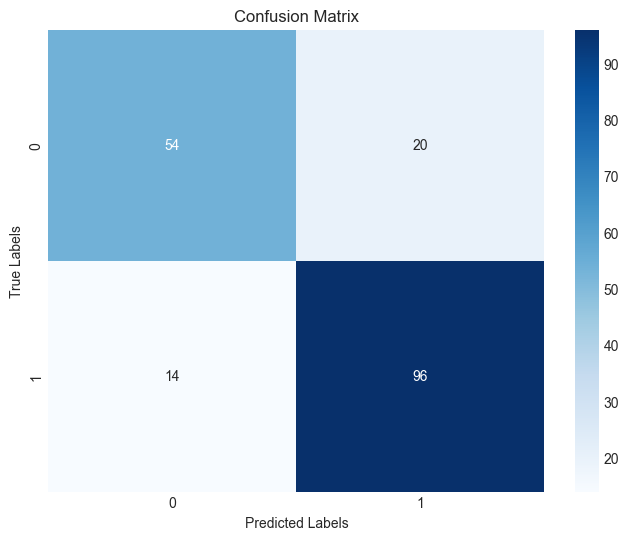

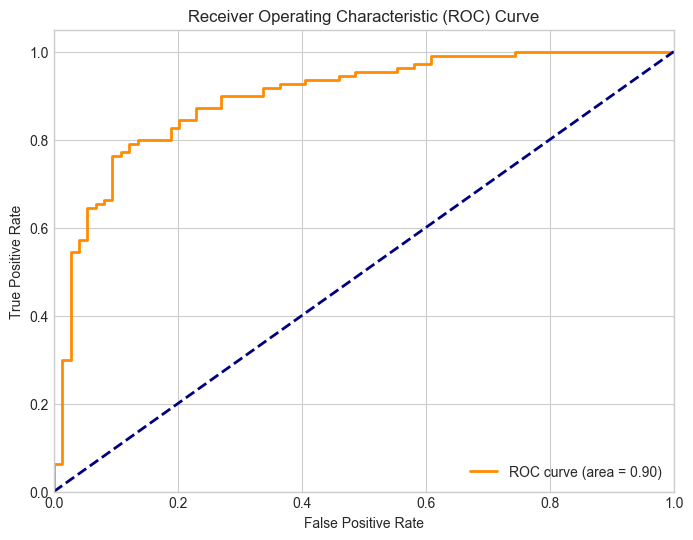

In [5]:
# Evaluation
y_pred = lasso_model.predict(X_test)
y_pred_proba = lasso_model.predict_proba(X_test)[:, 1]

# Calculate metrics
balanced_acc = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('data/confusion_matrix.png')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('data/roc_curve.png')
plt.show()


List of features with zero coefficients:
- RestingECG_ST

Features eliminated by Lasso (zero coefficients): 1 out of 15
Number of non-zero coefficients: 14 out of 15


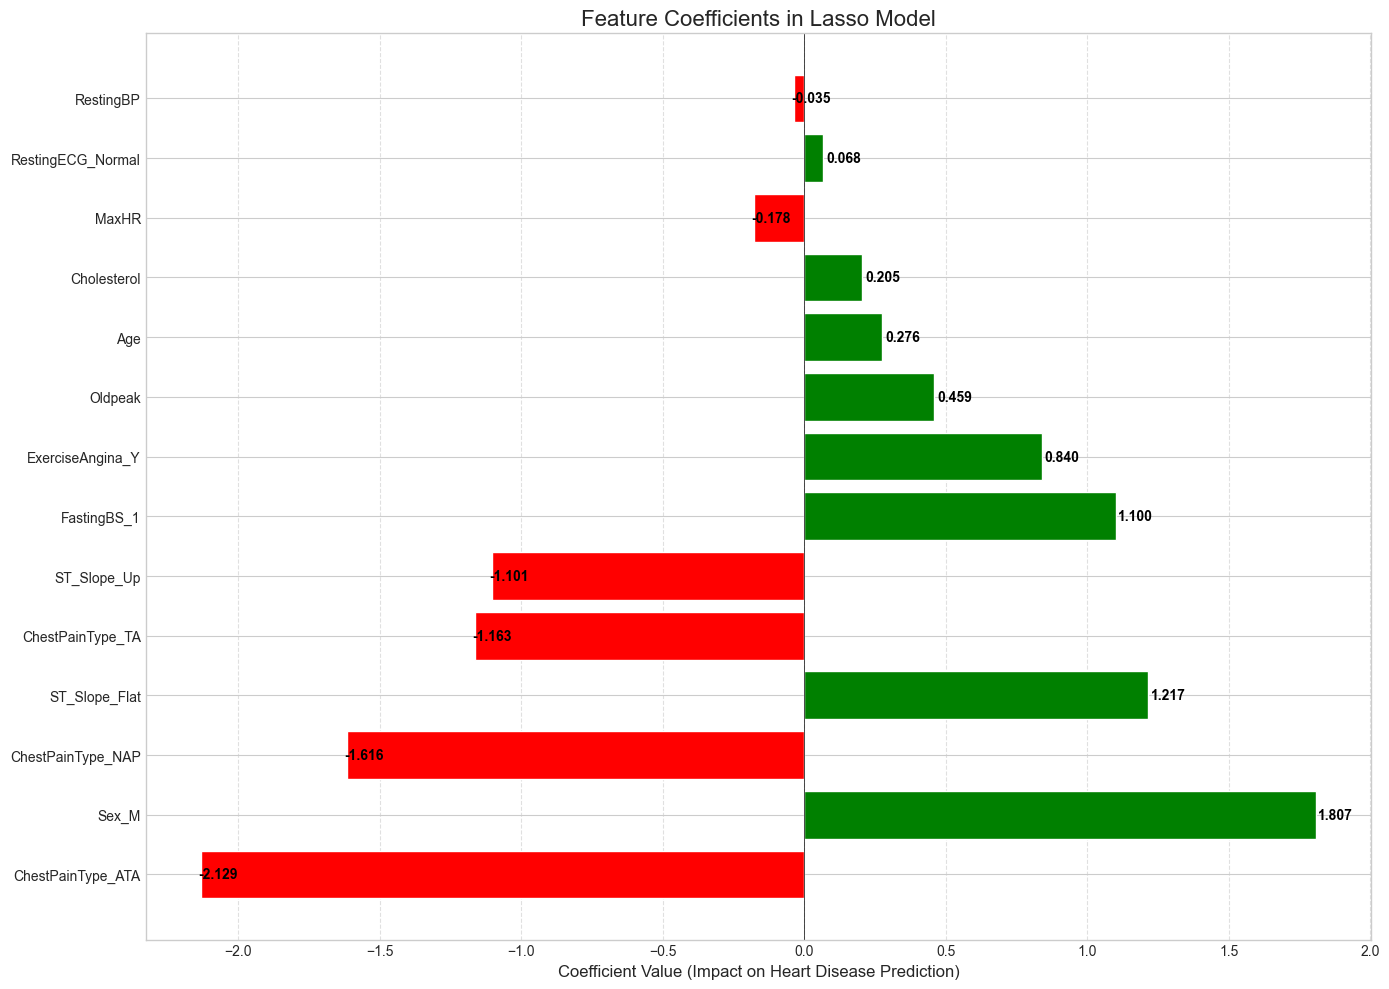

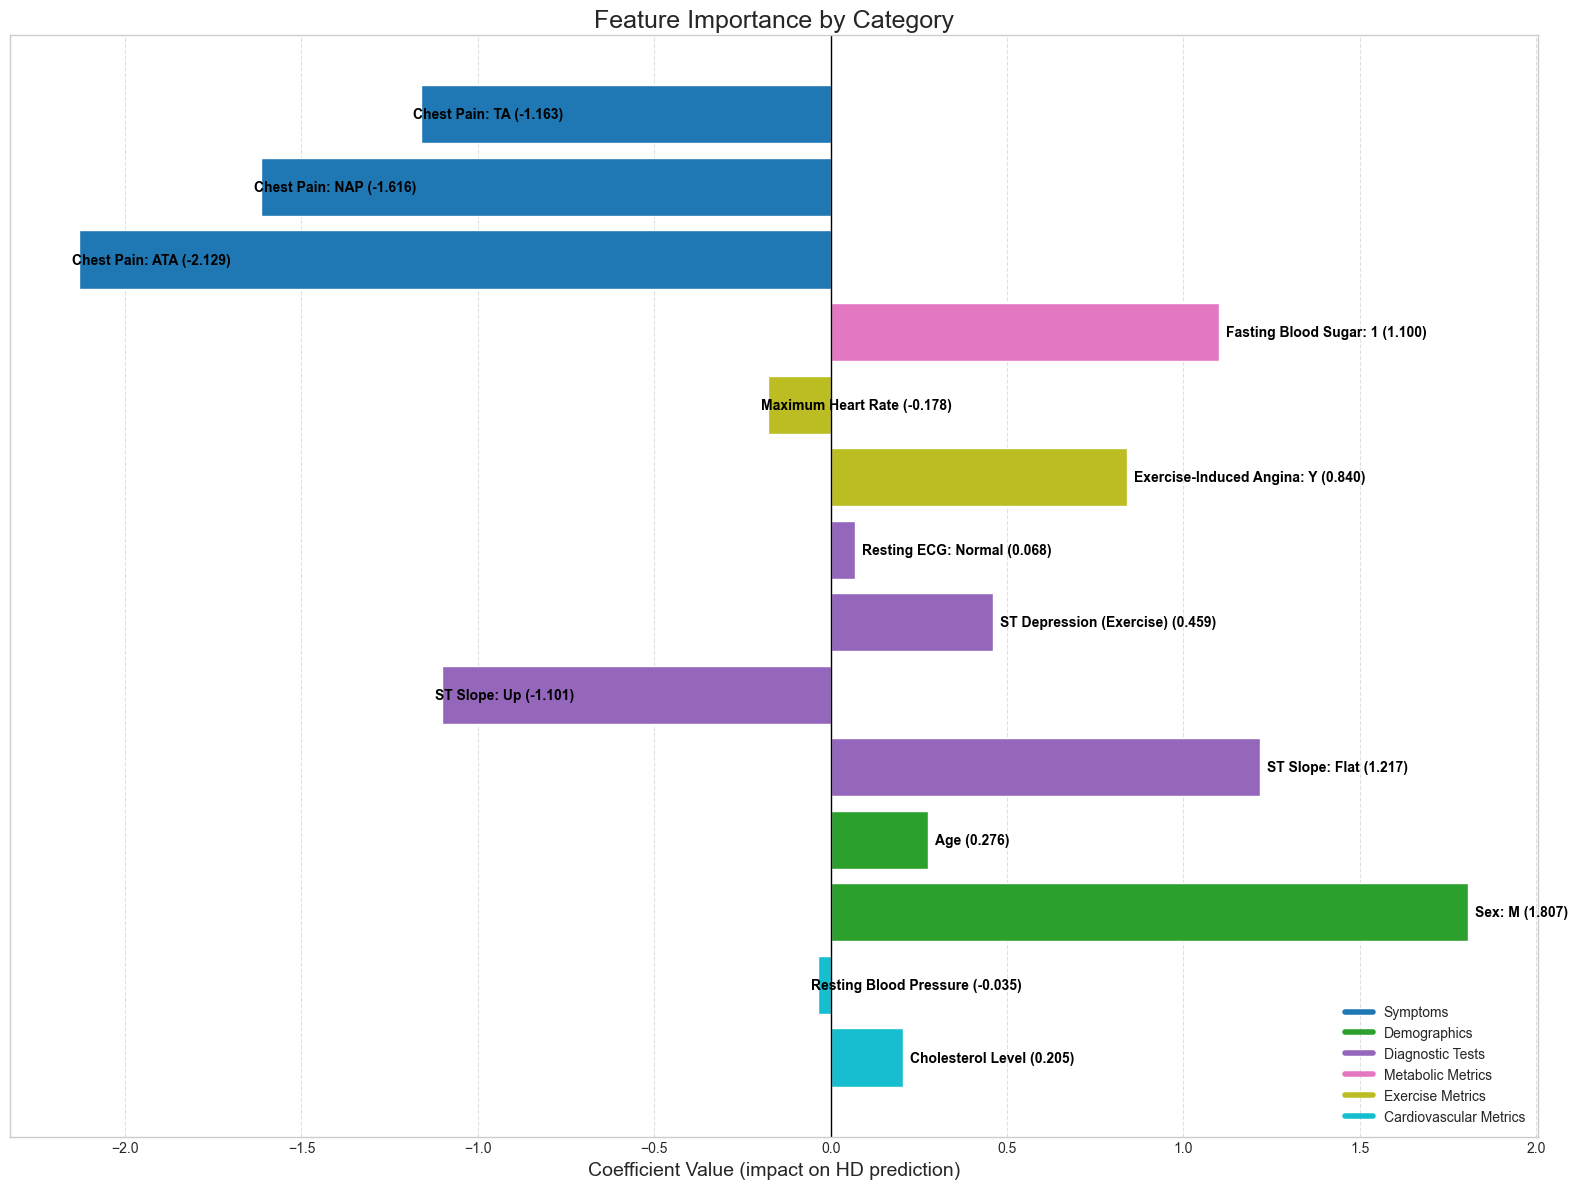

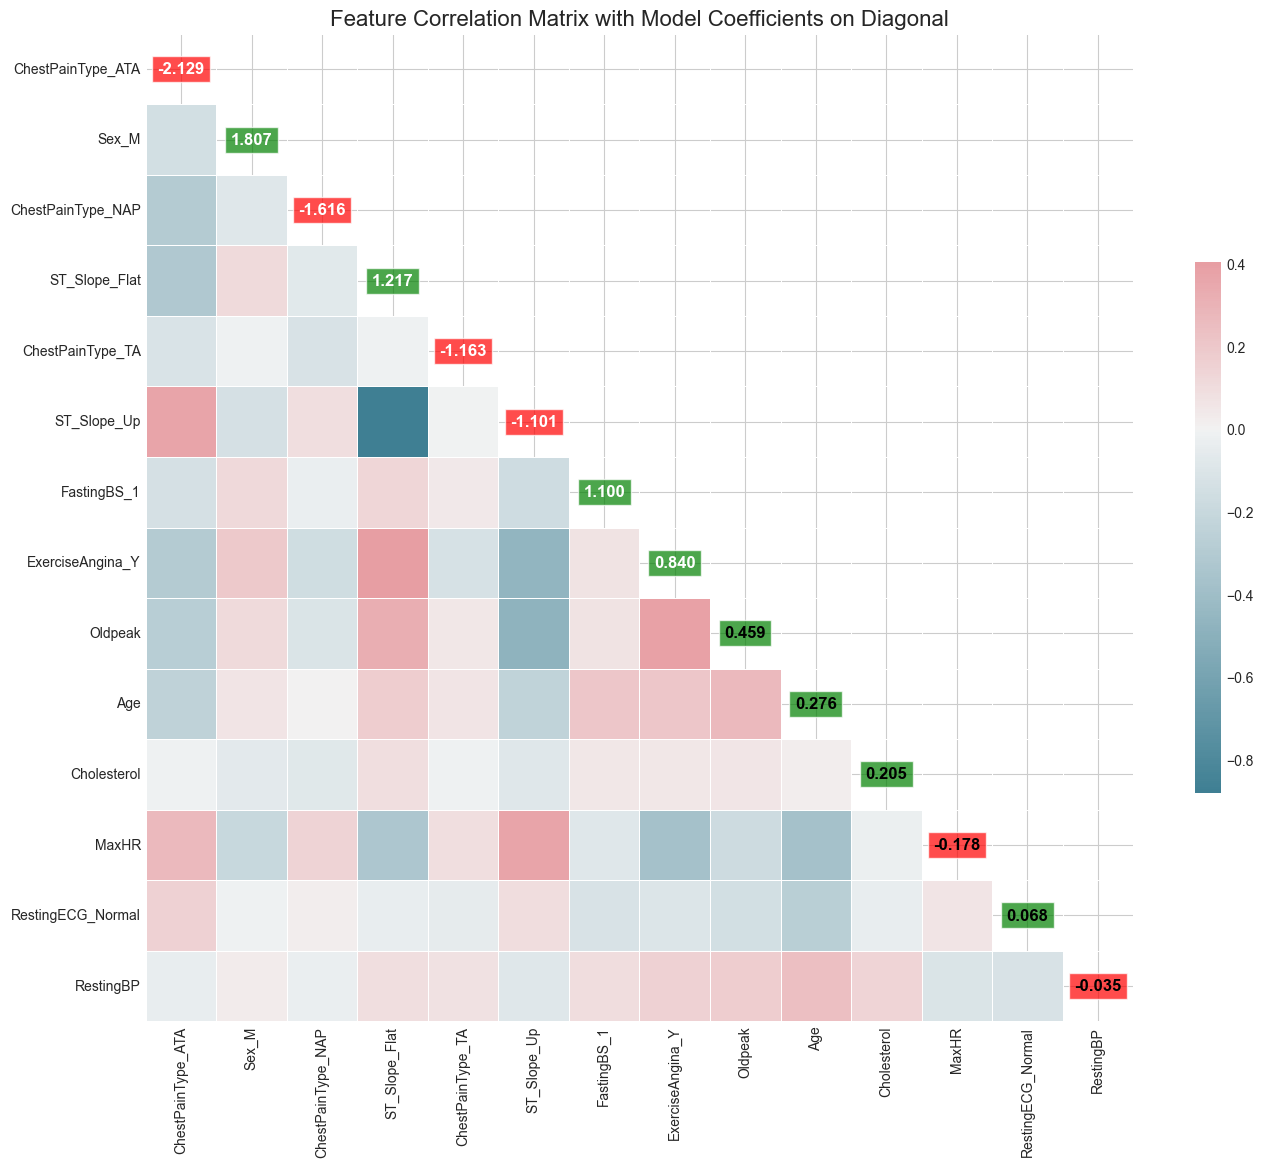


Top 5 most important features and their clinical significance:
1. Feature: Chest Pain: ATA - Coefficient: -2.129
   Clinical impact: This feature decreases the probability of heart disease.
2. Feature: Sex: M - Coefficient: 1.807
   Clinical impact: This feature increases the probability of heart disease.
3. Feature: Chest Pain: NAP - Coefficient: -1.616
   Clinical impact: This feature decreases the probability of heart disease.
4. Feature: ST Slope: Flat - Coefficient: 1.217
   Clinical impact: This feature increases the probability of heart disease.
5. Feature: Chest Pain: TA - Coefficient: -1.163
   Clinical impact: This feature decreases the probability of heart disease.

Model sparsity: 6.67% of features were eliminated by L1 regularization

Importance of feature categories:
                        Net Direction  Overall Importance
Category                                                 
Symptoms                           -3            4.907728
Diagnostic Tests                 

In [12]:
# Visualize importance of different features
coefficients = lasso_model.coef_[0]
feature_names = X_train.columns

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False) # Sorting 

non_zero_coef_df = coef_df[coef_df['Coefficient'] != 0].copy() # Filter out zero coefficients (features eliminated by Lasso)
zero_coef_df = coef_df[coef_df['Coefficient'] == 0].copy()
print("\nList of features with zero coefficients:")
for feature in zero_coef_df['Feature']:
    print(f"- {feature}")
    
    
print(f"\nFeatures eliminated by Lasso (zero coefficients): {len(zero_coef_df)} out of {len(coef_df)}")
print(f"Number of non-zero coefficients: {len(non_zero_coef_df)} out of {len(coef_df)}")

# --- Horizontal Bar Chart of Feature Importance ---
plt.figure(figsize=(14, 10))
colors = ['red' if c < 0 else 'green' for c in non_zero_coef_df['Coefficient']]
plt.barh(non_zero_coef_df['Feature'], non_zero_coef_df['Coefficient'], color=colors)
plt.title('Feature Coefficients in Lasso Model', fontsize=16)
plt.xlabel('Coefficient Value (Impact on Heart Disease Prediction)', fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.6)

for i, (feature, coef) in enumerate(zip(non_zero_coef_df['Feature'], non_zero_coef_df['Coefficient'])):
    plt.text(coef + (0.01 if coef > 0 else -0.01), i, f"{coef:.3f}", va='center', fontweight='bold',color='black')
plt.tight_layout()
plt.savefig('data/feature_coefficients_detailed.png', dpi=300)
plt.show()

# Feature Groups with Original Feature Names
def get_feature_category(feature_name):
    if 'Sex' in feature_name:
        return 'Demographics'
    elif 'Age' in feature_name:
        return 'Demographics'
    elif 'ChestPainType' in feature_name:
        return 'Symptoms'
    elif 'RestingBP' in feature_name:
        return 'Cardiovascular Metrics'
    elif 'Cholesterol' in feature_name:
        return 'Cardiovascular Metrics'
    elif 'FastingBS' in feature_name:
        return 'Metabolic Metrics'
    elif 'RestingECG' in feature_name:
        return 'Diagnostic Tests'
    elif 'MaxHR' in feature_name:
        return 'Exercise Metrics'
    elif 'ExerciseAngina' in feature_name:
        return 'Exercise Metrics'
    elif 'Oldpeak' in feature_name:
        return 'Diagnostic Tests'
    elif 'ST_Slope' in feature_name:
        return 'Diagnostic Tests'
    else:
        return 'Other'

def get_readable_name(feature_name):
    if feature_name == 'Age':
        return 'Age'
    elif feature_name == 'RestingBP':
        return 'Resting Blood Pressure'
    elif feature_name == 'Cholesterol':
        return 'Cholesterol Level'
    elif feature_name == 'MaxHR':
        return 'Maximum Heart Rate'
    elif feature_name == 'Oldpeak':
        return 'ST Depression (Exercise)'
    elif 'Sex_' in feature_name:
        return 'Sex: ' + feature_name.replace('Sex_', '')
    elif 'ChestPainType_' in feature_name:
        return 'Chest Pain: ' + feature_name.replace('ChestPainType_', '')
    elif 'FastingBS_' in feature_name:
        return 'Fasting Blood Sugar: ' + feature_name.replace('FastingBS_', '')
    elif 'RestingECG_' in feature_name:
        return 'Resting ECG: ' + feature_name.replace('RestingECG_', '')
    elif 'ExerciseAngina_' in feature_name:
        return 'Exercise-Induced Angina: ' + feature_name.replace('ExerciseAngina_', '')
    elif 'ST_Slope_' in feature_name:
        return 'ST Slope: ' + feature_name.replace('ST_Slope_', '')
    else:
        return feature_name

non_zero_coef_df['Category'] = non_zero_coef_df['Feature'].apply(get_feature_category)
non_zero_coef_df['ReadableFeature'] = non_zero_coef_df['Feature'].apply(get_readable_name)

plt.figure(figsize=(16, 12))
categories = non_zero_coef_df['Category'].unique()
category_colors = plt.cm.tab10(np.linspace(0, 1, len(categories)))
category_color_map = dict(zip(categories, category_colors))

grouped = non_zero_coef_df.groupby('Category')
plot_data = pd.DataFrame()
for category, group in grouped:
    sorted_group = group.sort_values('Abs_Coefficient', ascending=False)
    sorted_group['CategoryOrder'] = category
    plot_data = pd.concat([plot_data, sorted_group])

plot_data = plot_data.sort_values(['Category', 'Abs_Coefficient'], ascending=[True, False])

bars = plt.barh(y=range(len(plot_data)), width=plot_data['Coefficient'], 
        color=[category_color_map[cat] for cat in plot_data['Category']])
legend_elements = [Line2D([0], [0], color=category_color_map[cat], lw=4, label=cat) 
                  for cat in categories]
plt.legend(handles=legend_elements, loc='lower right')
for i, (feature, coef, readable_feature) in enumerate(zip(
    plot_data['Feature'], plot_data['Coefficient'], plot_data['ReadableFeature'])):
    text_color = 'black'
    plt.text(coef + (0.02 if coef > 0 else -0.02), 
             i, f"{readable_feature} ({coef:.3f})", va='center', fontweight='bold', color=text_color, fontsize=10)
plt.yticks([])
plt.title('Feature Importance by Category', fontsize=18)
plt.xlabel('Coefficient Value (impact on HD prediction)', fontsize=14)
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('data/feature_importance_by_category.png', dpi=300)
plt.show()

# --- Heatmap of Feature Correlations with Coefficient Overlay --- 
selected_features = non_zero_coef_df['Feature'].tolist()
correlation_matrix = X_train[selected_features].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
coef_dict = dict(zip(non_zero_coef_df['Feature'], non_zero_coef_df['Coefficient']))
plt.figure(figsize=(14, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
heatmap = sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, annot=False, cbar_kws={"shrink": .5})

for i, feature in enumerate(correlation_matrix.columns):
    coef = coef_dict[feature]
    text_color = 'white' if abs(coef) > 0.5 else 'black'
    plt.text(i+0.5, i+0.5, f"{coef:.3f}", 
              ha="center", va="center", 
              color=text_color,
              fontweight='bold',
              fontsize=12,
              bbox=dict(facecolor='red' if coef < 0 else 'green', alpha=0.7))

plt.title('Feature Correlation Matrix with Model Coefficients on Diagonal', fontsize=16)
plt.tight_layout()
plt.savefig('data/feature_correlation_with_coefficients.png', dpi=300)
plt.show()

# 6. Analysis and Interpretation
# Sort features by absolute coefficient value (importance)
top_features = non_zero_coef_df.head(5)
print("\nTop 5 most important features and their clinical significance:")
for i, (feature, coef, readable) in enumerate(zip(
    top_features['Feature'], top_features['Coefficient'], top_features['ReadableFeature'])):
    direction = "increases" if coef > 0 else "decreases"
    significance = f"Feature: {readable} - Coefficient: {coef:.3f}"
    print(f"{i+1}. {significance}")
    print(f"   Clinical impact: This feature {direction} the probability of heart disease.")

sparsity = 1 - (len(non_zero_coef_df) / len(coef_df))
print(f"\nModel sparsity: {sparsity:.2%} of features were eliminated by L1 regularization")

category_summary = non_zero_coef_df.groupby('Category').agg({
    'Coefficient': lambda x: sum(x > 0) - sum(x < 0),  # Net positive or negative impact
    'Abs_Coefficient': 'sum'  # Total magnitude of impact
}).sort_values('Abs_Coefficient', ascending=False)

category_summary.columns = ['Net Direction', 'Overall Importance']

print("\nImportance of feature categories:")
print(category_summary)

print("\nClinical Interpretation Summary:")
print("""
Based on the feature importance visualization, we can draw several clinically relevant conclusions:
1. Symptom Features:
   Chest pain characteristics are highly predictive, with certain types strongly associated with 
   heart disease. This aligns with clinical knowledge that specific chest pain patterns (like 
   typical angina) are key indicators of coronary artery disease.
2. Exercise Response Metrics:
   Exercise-induced angina and ST depression (Oldpeak) during exercise are strong predictors.
3. Cardiovascular Metrics:
   Resting blood pressure, cholesterol levels, and maximum heart rate provide insights into
   the cardiovascular system's overall health.
4. Diagnostic Test Results:
   ECG findings and ST slope characteristics contribute significant predictive value.
""")

### Q2.5 Logistic Regression only on most important features

A researcher is interested in the important variables and their influence on the label. They have fitted the Logistic Lasso Regression to determine the important variables. Then, they train a Logistic Regression solely on these variables and use this model to make conclusions. Elaborate why this would be a good or bad idea.

Using Lasso regression to identify important features, and then training a separate logistic regression model on those selected variables, is an approach that appeals due to its apparent simplicity, reduced overfitting risk and focus on interpretability. However, we think this method has serious statistical flaws that can undermine the validity of any conclusions drawn. The primary issue lies in the invalid statistical inference this approach creates. When you use the same dataset for both feature selection and coefficient estimation, you're essentially "peeking" at the data twice. This introduces a selection bias that isn't accounted for in the standard errors of the subsequent logistic regression. The p-values and confidence intervals produced by the second model are misleading because they don't reflect the uncertainty in the feature selection process itself. This approach also struggles with correlated predictors. Lasso tends to arbitrarily select one variable from a group of correlated features, potentially excluding clinically important variables that happen to be correlated with others. In the context of heart disease, where risk factors often cluster together, this could lead to incomplete or misleading conclusions about which factors truly influence cardiac health. For exploratory analysis, this might be acceptable as a preliminary step, but findings should be validated with proper confirmatory analyses. Instead of this two-step process, researchers could use Lasso directly and interpret the non-zero coefficients, employ bootstrapping to quantify uncertainty in feature importance, consider elastic net to better handle correlated features and / se domain knowledge.